# Get Current Forecast

read out the forecast for different companies for today. Source of forecast data is [https://kursprognose.com](https://kursprognose.com)

In [2]:
from finance_monitor.forecastgrapper import ForecastGrapper
fcg = ForecastGrapper()

Forecast data saved to 20250418_nvidia_forecast.csv
Forecast data saved to 20250418_nvidia_forecast.csv
Current stock price of nvidia is 101.49 USD / 89.24 EUR


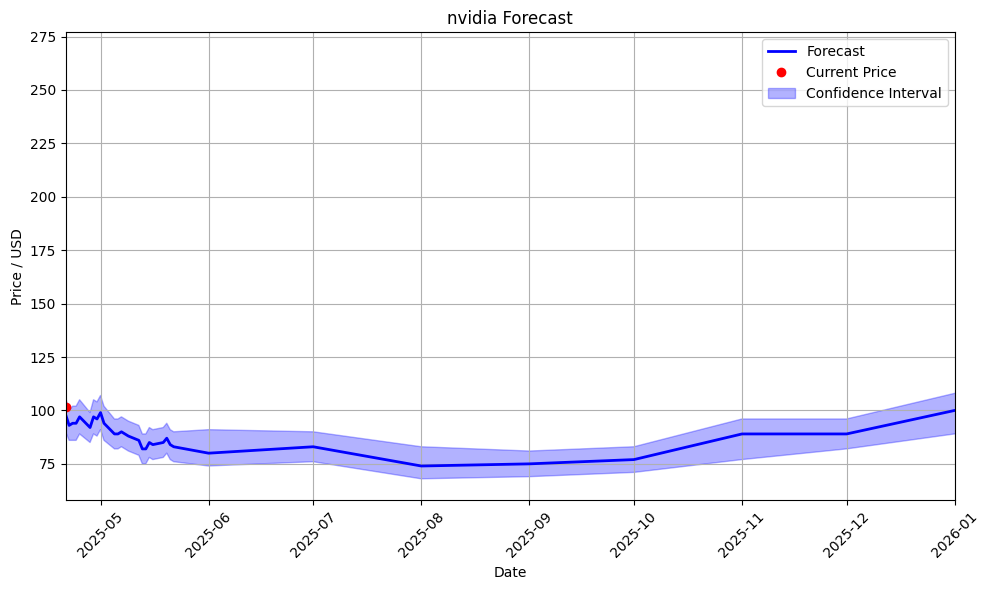

In [3]:
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast(31)

Forecast data saved to 20250418_rhm-aktie_forecast.csv
Forecast data saved to 20250418_rhm-aktie_forecast.csv
Current stock price of rhm-aktie is 1671.15 USD / 1469.44 EUR


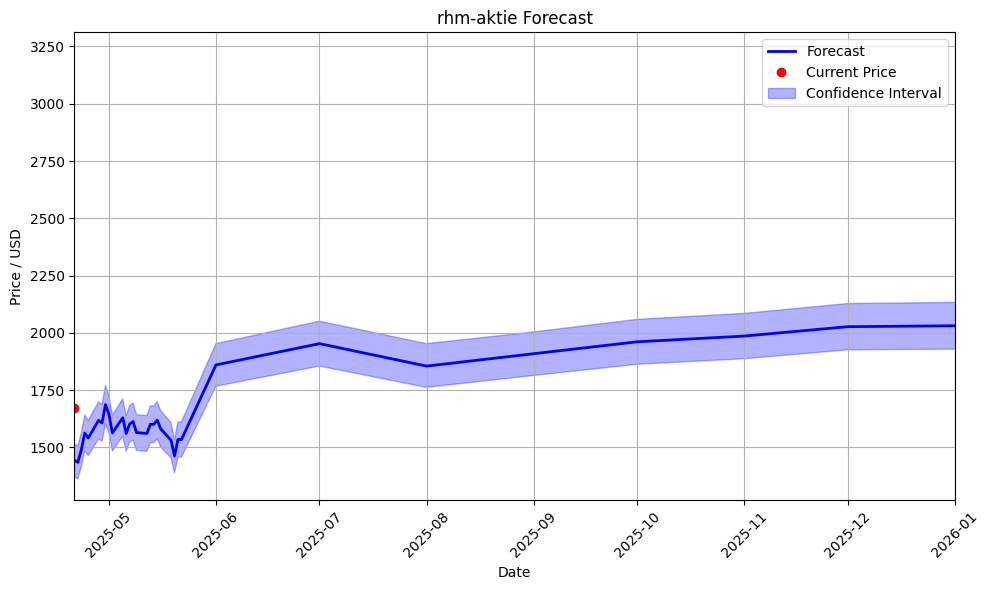

In [4]:
fcg.set_company("rhm-aktie")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast(31)

Forecast data saved to 20250418_tesla_forecast.csv
Forecast data saved to 20250418_tesla_forecast.csv
Current stock price of tesla is 241.37 USD / 212.24 EUR


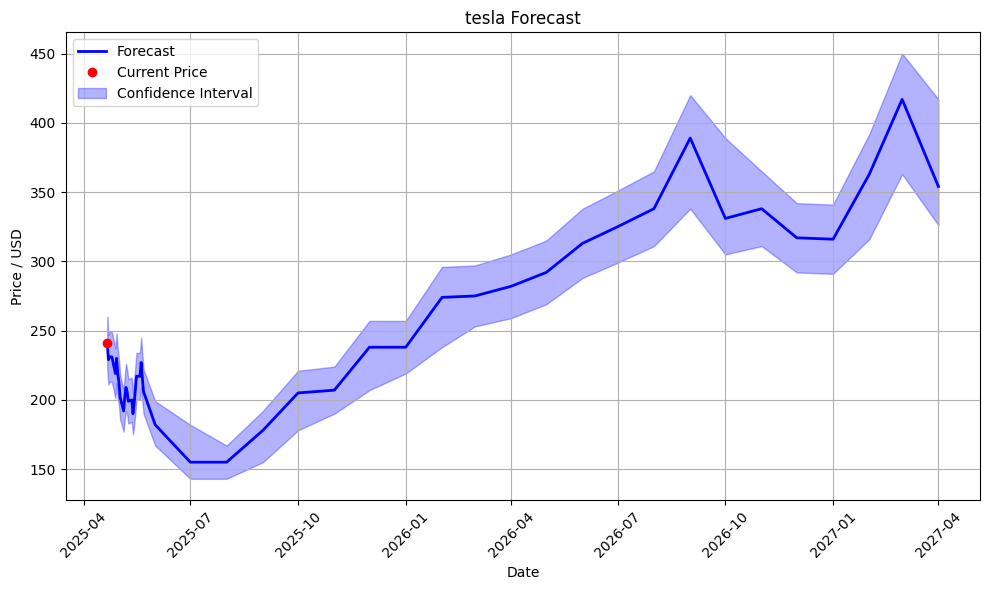

In [5]:
fcg.set_company("tesla")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250418_netflix_forecast.csv
Forecast data saved to 20250418_netflix_forecast.csv
Current stock price of netflix is 973.03 USD / 855.59 EUR


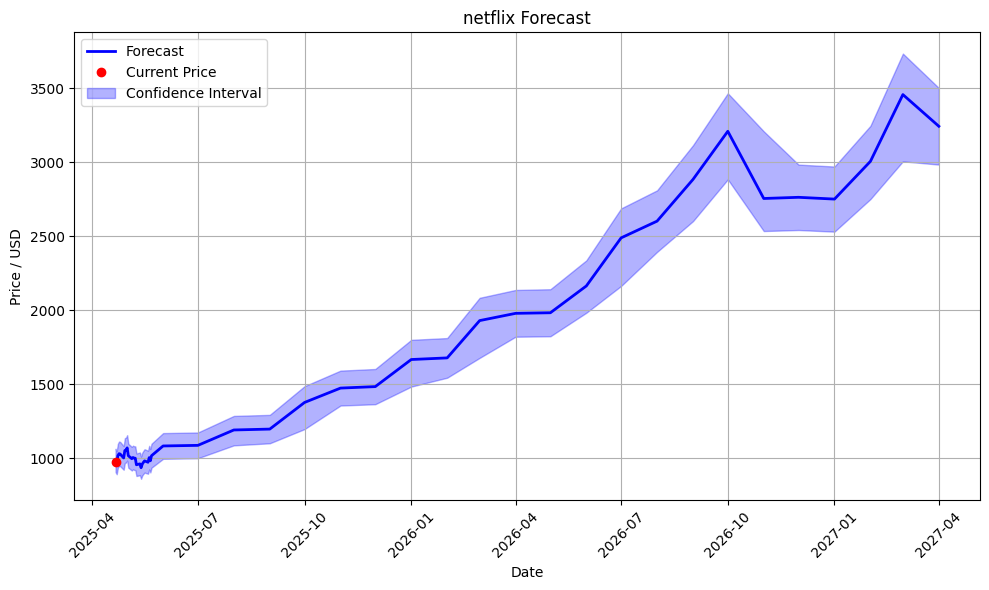

In [6]:
fcg.set_company("netflix")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250418_wmt-stock_forecast.csv
Forecast data saved to 20250418_wmt-stock_forecast.csv
Current stock price of wmt-stock is 93.22 USD / 81.97 EUR


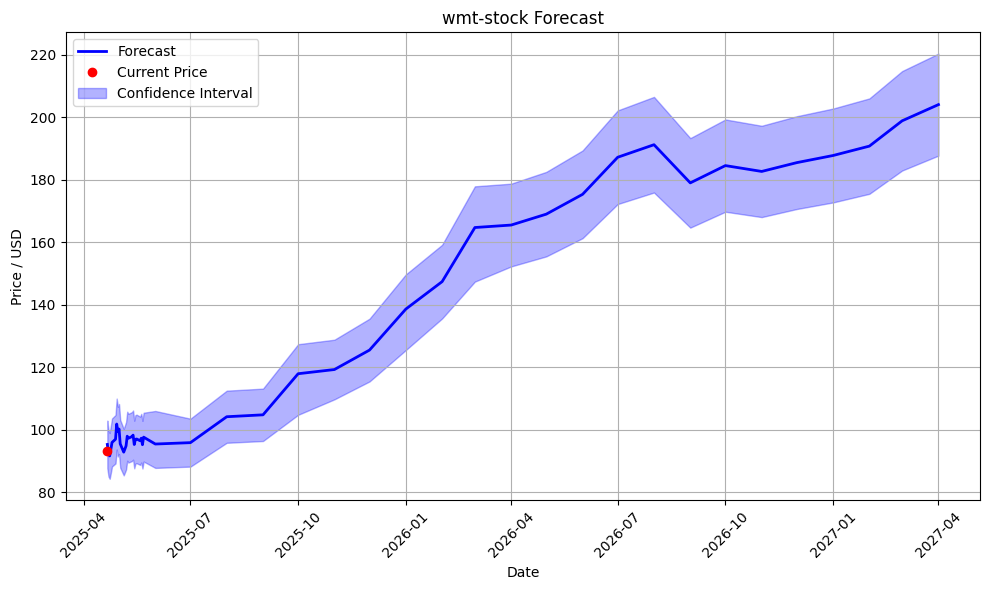

In [7]:
fcg.set_company("wmt-stock")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250418_xpeng_forecast.csv
Forecast data saved to 20250418_xpeng_forecast.csv
Current stock price of xpeng is 18.22 USD / 16.02 EUR


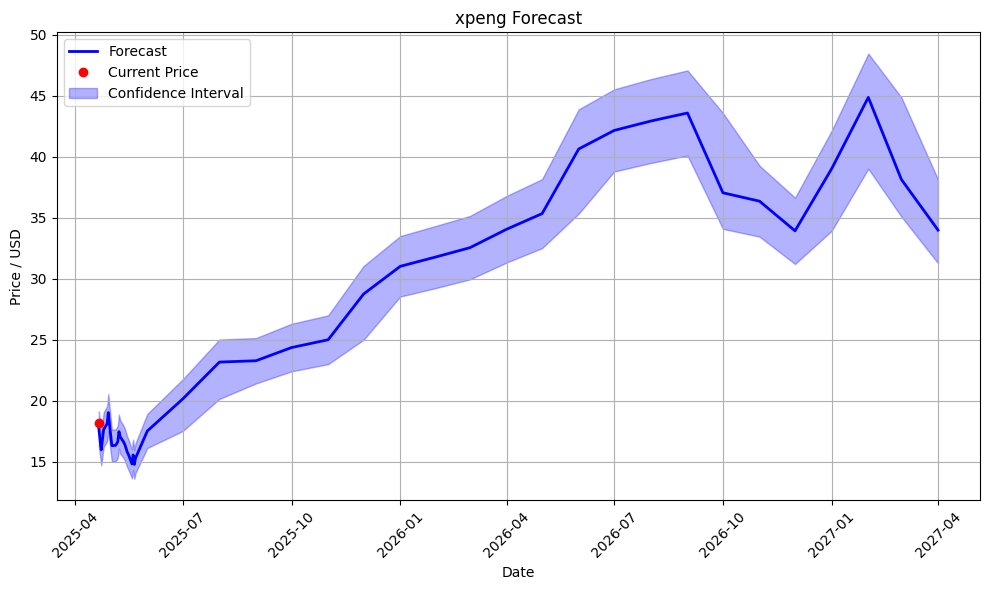

In [8]:
fcg.set_company("xpeng")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()

Forecast data saved to 20250418_mo-stock_forecast.csv
Forecast data saved to 20250418_mo-stock_forecast.csv
Current stock price of mo-stock is 58.16 USD / 51.14 EUR


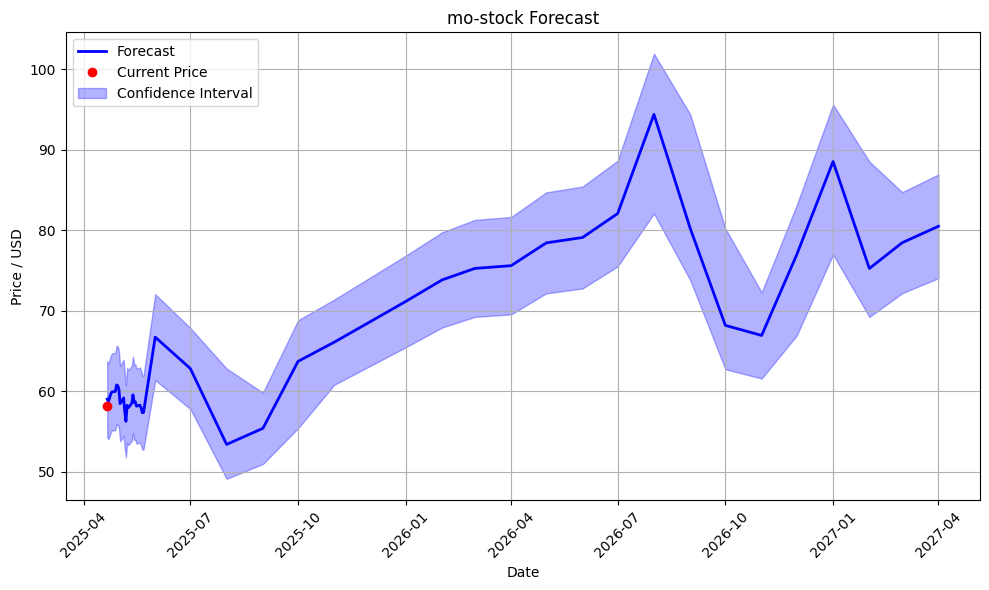

In [9]:
fcg.set_company("mo-stock")
fcg.grap_forecast()
fcg.save_forecast()
fcg.plot_forecast()